In [2]:
#import files
%matplotlib inline

import os
from pathlib import Path
import shutil
import re

import tifffile
import glob
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Image Processing Demonstration
To process images, here is the general file organization that we will need.
```
base_directory/ 
├── working_directory/
│   ├── data/ 
│   │   ├── autofluorescence_directory/ 
│   │   │   └── ...tif
│   │   └── signal_directory/ 
│   │       └── ...tif
│   ├── analysis/
│   │   └── ...
│   ├── parameter.py
│   └── process.py
├── filters/
│   └── ilastik_filter.ipl
├── 00_bq3d_setup.ipynb
├── 01_bq3d_tutorial.ipynb
├── parameter_template.py
├── process_template.py
├── 01_bq3d_tutorial.ipynb
└── bq3d_env.json
```
We will need to manually update the parameter.py file with a few paths to ensure the process.py pipeline is accessing the correct folders.
This notebook will create the working directory folder.

## 0.5. Ensure that the Jupyter Notebook kernel has been changed to the "bq3d" environment!
You can modify this in the Kernel > Change Kernel option in the menu bar.

## 1. Create working directory and set up as a variable in parameter.py
First, create the folder that will serve as the working directory where the analysis and data folders will be stored. The process.py and parameters.py files will be copied over. 

In [3]:
base_directory = Path.cwd()
print("base directory path:", base_directory)

working_directory_name = "data_subset"  #NOTE: change this to any desired base directory name

#create a base folder in the working directory
working_directory = Path(base_directory, working_directory_name)
Path(working_directory).mkdir(parents=True, exist_ok=True)

#copy parameter and process files from the base directory into the working directory
if "parameter" not in [path.stem for path in Path(working_directory).iterdir() if path.is_file()]:
    print(f"copying parameter and process files into {working_directory} ...")
    shutil.copy(Path(base_directory, "parameter_template.py"), Path(working_directory, "parameter.py"))
    shutil.copy(Path(base_directory, "process_template.py"), Path(working_directory, "process.py"))
    print(f"done")

#create data and analysis folders
if "data" not in [path.stem for path in Path(working_directory).iterdir() if path.is_file()]:
    Path(working_directory, "data").mkdir(parents=True, exist_ok=True)
    
if "analysis" not in [path.stem for path in Path(working_directory).iterdir() if path.is_file()]:
    Path(working_directory, "analysis").mkdir(parents=True, exist_ok=True)

base directory path: /mnt/d/brainquant_RC/bq3d_demo


You will need to change the WorkingDirectory variable in the working_directory/parameter.py file so the program knows the path to the working directory:

In [4]:
print(f"\nReplace these variables in working_directory/parameter.py (line 11):\nWorkingDirectory = str(Path('{working_directory}'))")


Replace these variables in working_directory/parameter.py (line 11):
WorkingDirectory = str(Path('/mnt/d/brainquant_RC/bq3d_demo/data_subset'))


## 2. Move data into the working directory and set up as a variable in parameter.py
Download the demo data (78.6 MB unzipped): https://osf.io/wyxa5/?view_only=f0cc945410554286b78c10e41ab511bb

Press the "OSF Storage (Canada - Montreal)" tab underneath "Demo Data Subset" in the file tree, and then select "Download as zip" to unwrap all the files.

The data directory contains all of your raw data.

The signal directory contains the path to your images from the signal channel (ie. cfos images).

The autofluorescence directory contains the path to your images from the autofluorescent channel (ie. background images).

Move the downloaded data files into the working_directory/data directory. Ensure that two separate folders containing separated autofluorescence and signal TIF images are within the data directory. 

We will update the parameters.py file here too.

In [5]:
#get subfolders of the raw data
data_subfolders = [path for path in Path(working_directory, "data").iterdir() if path.is_dir()]
assert len(data_subfolders) != 0, "Make sure to move the directories into the working directory's data subfolder!"

print("found these directories in the working_directory/data folder:",[path.stem for path in data_subfolders])

try:
    #adjust the order as necessary
    autofluorescence_directory = data_subfolders[0] 
    signal_directory = data_subfolders[1] 

    # uncomment in case the folder order is reversed
    # autofluorescence_directory = data_subfolders[1] 
    # signal_directory = data_subfolders[0] 

    print("\nAre the following paths correct?")
    print("autofluorescence files are located in",autofluorescence_directory.stem)
    print("signal files are located in",signal_directory.stem)
    print("\nIf the order is incorrect, swap the order of the files by uncommenting lines 10-11 in this code block.")
except Exception as e:
    print(f"Exception: {e} -- make sure to move both of the autofluorescence and signal folders into the working_directory/data directory!")

found these directories in the working_directory/data folder: ['background', 'signal']

Are the following paths correct?
autofluorescence files are located in background
signal files are located in signal

If the order is incorrect, swap the order of the files by uncommenting lines 10-11 in this code block.


You will need to change the AutofluoFile and SignalFile variables in the working_directory/parameter.py file so the program knows where to find the autofluorescence and signal image files:

In [6]:
#replace regex as necessary-- consider which variables in the image name are marking the Z-index. 
autofluo_regex = re.sub(r"Z\d{3,4}", "Z\\\d{3,4}", [path.stem for path in autofluorescence_directory.iterdir()][0])
signal_regex = re.sub(r"Z\d{3,4}", "Z\\\d{3,4}", [path.stem for path in signal_directory.iterdir()][0])

print(f'replace these variables in parameter.py (lines 16, 18=7):\nAutofluoFile = str(Path(DataDirectory, "{autofluorescence_directory.stem}", "{autofluo_regex}.tif"))\nSignalFile = str(Path(DataDirectory, "{signal_directory.stem}", "{signal_regex}.tif"))')

replace these variables in parameter.py (lines 16, 18=7):
AutofluoFile = str(Path(DataDirectory, "background", "NN_428180_463220_025000_left_T001_Z\d{3,4}_C01.tif"))
SignalFile = str(Path(DataDirectory, "signal", "787287_428180_463220_025000_full_sagittal_left_T001_Z\d{3,4}_C01.tif"))



> NOTE: The paths in parameters.py contain “\d{3,4}”. This is path is actually a regex (regular expression), which uses this specific notation. The function of a regex is for pattern matching. We can gather a large number of files from a directory that match this pattern.
> 
> In our case, the TIF files in the data/787287_NN_left_hemi_grayscale folder are in this format: “NN_428180_463220_025000_left_T001_Z**003**_C01.tif”, “NN_428180_463220_025000_left_T001_Z**006**_C01.tif”, “NN_428180_463220_025000_left_T001_Z**009**_C01.tif”... Notice that the numbers after Z are the only parts that change for each path. 
> 
> Even though each path is different, the pattern that all the paths share is “NN_428180_463220_025000_left_T001_Z **[three numbers in a row]**_C01.tif”. “\d{3,4}” is the regex pattern that matches for **[three numbers in a row]**: 
> - \d matches a single digit between 0-9 inclusive, and
> - {3,4} means allow for the previous expression to repeat 3 to 4 times.
> 
> The code in the cell above creates a regex that matches our files and may not be compatible with your formatting. For your own image files, you can find regex references and test an appropriate regex at this website: https://regex101.com/

## 2.a) Info on data/images and the parameter.py file
The TIF images included on OSF have been obtained using a Zeiss Z.1 light sheet microscope with a large-sized chamber (Translucence BioSystems) to allow for whole brain imaging.  Data has been stitched and each hemi has been exported in tif format (ie. we run on one hemi at a time).  The original data resolution is #### but we down-sampled the images to 9x9x9um.

> NOTE: the tif files are not in the correct orientation in regards to the atlas (must match for proper registration).
> 
> While we have already set up the parameter.py file accordingly for the data, if yours is in a different orientation, we must adjust the FinalOrientation values (in the order Z, Y, X). 

If the image does not require adjustment, you will input (1, 2, 3).  If any inverting must be done, add a (-) to that axes.  In our case, we must invert over Y, so we input `FinalOrientation = (1, -2, 3)`. For another example, `FinalOrientation = (-1, 2, -3)` will invert the Z and X axes.

## 3. Change variable in the ilastik.py bq3d file to use an ilastik filter
Rather than using BrainQuant3d’s tutorial default filter (RollingBackgroundSubtract), we will be utilizing the Ilastik filter feature (PixelClassification) to allow us to more accurately segment cfos cells.

First, we will locate the ilastik.py file on your computer. Please open the .py file up in your text editor of choice."

In [22]:
import bq3d
#find the ilastik folder in the bq3d package
bq3d_package_directory = Path(bq3d.__file__).parent
ilastik_file = Path(bq3d_package_directory, "image_filters", "filters", "ilastik.py")

assert ilastik_file.is_file(), f'cannot find ilastik file at {ilastik_file}'

print(f"Edit the ilastik.py file by entering this in the command line:\nnano {ilastik_file}\n\nHINT: Use the arrow keys to navigate through the file. You can right-click to paste text from your clipboard.")

Edit the ilastik.py file by entering this in the command line:
nano /home/ninc-user/miniconda3/envs/bq3d/lib/python3.9/site-packages/bq3d/image_filters/filters/ilastik.py

HINT: Use the arrow keys to navigate through the file. You can right-click to paste text from your clipboard.


Second, we want to find the specific .ilp file to put into the ilastik.py file:

In [19]:
ilp_files = glob.glob(str(Path(base_directory,"filters","*.ilp")),recursive=True)
print("Found these .ilp ilastik filter files in the base directory:", ilp_files)

Found these .ilp ilastik filter files in the base directory: ['/mnt/d/brainquant_RC/bq3d_demo/filters/cfos_6h_nov2.ilp']


Finally, we want to replace the self.project variable in the ilastik.py file with the filter path that you would like to use:

In [24]:
print(f"\nReplace variable in ilastik.py file (line 50) with the desired ilp file from list above. For example, it should look like this:\nself.project = '{ilp_files[0]}'\n\nSave the file with the 'Exit' command (usually ^X), followed by Y, and then Enter.")


Replace variable in ilastik.py file (line 50) with the desired ilp file from list above. For example, it should look like this:
self.project = '/mnt/d/brainquant_RC/bq3d_demo/filters/cfos_6h_nov2.ilp'

Save the file with the 'Exit' command (usually ^X), followed by Y, and then Enter.


## 4. Check if you have the Brain Atlas Registration path set up in parameter.py
Find the PathReg variable in parameter.py (line 35) and confirm that it is correct. Make sure that you have your Brain Atlas Registration path set up if you haven't already.

In [26]:
brain_atlas_directory = "/mnt/d/brainquant_RC/bq3d_demo/Warping" #!!! modify the path to the downloaded brain atlas directory on your computer

assert any(Path(brain_atlas_directory).iterdir()), "No files found in the brain atlas directory. Make sure that the path is correct!"

print(f"\nreplace this variable in parameter.py (line 35) if it has not been set already:\nPathReg = str(Path('{brain_atlas_directory}'))")


replace this variable in parameter.py (line 35) if it has not been set already:
PathReg = str(Path('/mnt/d/brainquant_RC/bq3d_demo/Warping'))


# Check TIF files
use FIJI or run the code below to look at the TIF files that will be processed. The code block below will combine all the tif files in the data folder into a stack.

In [27]:
combined_tifs = {} #key as the folder name, value as 3xNxM arrays of intensities (tifffile images)
for path in data_subfolders:
    combined_tifs[path.stem] = tifffile.imread(glob.glob(str(path)+"/*.tif"))

This code will average all pixels across the z-axis of the stack.

787287_NN_left_hemi_grayscale tif shape (Z, Y, X): (247, 2049, 867)
787287_cfos_left_hemi_grayscale tif shape (Z, Y, X): (247, 2049, 867)


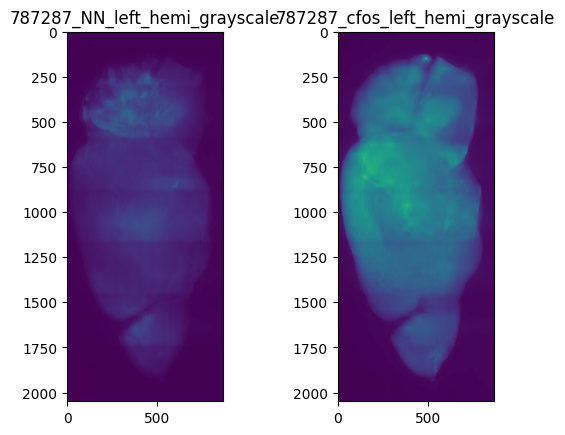

In [29]:
#explore data-- average across z axis
fig, ax = plt.subplots(nrows=1, ncols=len(combined_tifs))
for i, subfolder in enumerate(combined_tifs.keys()):
    print(f"{subfolder} tif shape (Z, Y, X):", combined_tifs[subfolder].shape)
    ax[i].imshow(combined_tifs[subfolder].mean(axis=0),vmin=0, vmax=1000)
    ax[i].set_title(subfolder)

This code will allow you to look at the images on specific layers of the stack.

In [18]:
# https://stackoverflow.com/questions/58489679/continious-update-of-matplotlib-plot-in-jupyter
from IPython.display import display, clear_output
import ipywidgets as ipy
import matplotlib.pyplot as plt
import numpy as np

###NOTE: comment/uncomment to look at figures in specific folder:
folder = '787287_cfos_left_hemi_grayscale'
#folder = '787287_NN_left_hemi_grayscale'

image_stack = combined_tifs[folder]

out = ipy.Output()

# show random mesh
def update(idx):
    with out:
        clear_output()
        fig, ax = plt.subplots(figsize = (5,5))
        ax.imshow(image_stack[slider.value], vmin=0, vmax=500) ###NOTE: you may need to adjust vmax for the optimal render.
        # h.set_data(np.ma.masked_less_equal(image_stack[0], slider.value))
        fig.canvas.flush_events()
        fig.canvas.draw()
        plt.show()

slider = ipy.IntSlider(min = 0, max = len(image_stack)-1, orientation = 'vertical')
widget = ipy.interactive(update, idx = slider)

layout = ipy.Layout()

widgets = ipy.HBox(children=(slider, out), layout = layout)
display(widgets)

# 3. Run processing!

In [8]:
os.chdir(Path(working_directory))

In [9]:
!pwd
!python process.py #replace lifecanvas with the name of your working directory

/Users/ytcao/Documents/GitHub/bq3d_demo/data_subset
VERBOSE |15:17:49| Copying raw data to: /tmp/bq3d99046496-423c-452e-8524-b1944c00fbc8/e849d781-1e02-408e-abe9-d417f0cb73a5.tif
VERBOSE |15:17:50| Number of chunks: 1
INFO    |15:17:50| chunk ranges: z= [0, 247], y= [0, 2049], x = [0, 867]
INFO    |15:17:50| Creating memory mapped substack at: /tmp/bq3d99046496-423c-452e-8524-b1944c00fbc8/run6123f246-ffff-47cf-af3b-a1a4773a58cb/51c1b11b-1ca0-4f08-833f-015688fe247c.tif
INFO    |15:17:53| Creating raw substack at: /tmp/bq3d99046496-423c-452e-8524-b1944c00fbc8/run6123f246-ffff-47cf-af3b-a1a4773a58cb/42ebe3b8-8a65-485c-b891-ccf5dad67321.tif
VERBOSE |15:17:55| PixelClassification| ram: 4
VERBOSE |15:17:55| PixelClassification| processes: 1
VERBOSE |15:17:55| PixelClassification| project: /Users/ytcao/Documents/GitHub/bq3d_demo/filters/cfos_6h_nov2.ilp
VERBOSE |15:17:55| PixelClassification| output_channel: 0
VERBOSE |15:17:55| PixelClassification| cleanup: False
VERBOSE |15:17:55| PixelClas

In [10]:
!pwd
!python process.py #replace lifecanvas with the name of your working directory

/Users/ytcao/Documents/GitHub/bq3d_demo/data_subset
INFO    |15:58:46| resampling points
VERBOSE |15:58:46| voxelizing points
INFO    |15:58:46| Processed 0/87124
INFO    |15:58:46| Processed 25000/87124
INFO    |15:58:46| Processed 50000/87124
INFO    |15:58:46| Processed 75000/87124
INFO    |15:58:46| transforming points with /Users/ytcao/Documents/GitHub/bq3d_demo/data_subset/analysis/ants_signal_to_auto
INFO    |15:58:46| invert: True
VERBOSE |15:58:46| voxelizing points
INFO    |15:58:46| Processed 0/87124
INFO    |15:58:46| Processed 25000/87124
INFO    |15:58:46| Processed 50000/87124
INFO    |15:58:46| Processed 75000/87124
INFO    |15:58:46| resampling points
INFO    |15:58:46| resampling points
VERBOSE |15:58:46| voxelizing points
INFO    |15:58:46| Processed 0/87124
INFO    |15:58:46| Processed 25000/87124
INFO    |15:58:46| Processed 50000/87124
INFO    |15:58:46| Processed 75000/87124
INFO    |15:58:46| transforming points with /Users/ytcao/Documents/GitHub/bq3d_demo/data_

# 4. Results
Once the code has successfully run, the following files should be available in the analysis folder of your base directory:
```
├── ants_auto_to_atlas/
│   └── ants_signal_to_auto/
│       ├── autofluo_resampled_12.tif
│       ├── autofluo_resampled_25.tif
│       └── cells_atlas.csv
├── Cells_atlas.tif
├── cells_cd1.tif
├── cells_corr.tif
├── cells_ds.tif
├── cells.json
├── cells_transformed.json
└── labels/
    ├── signal_resampled_12.tif
    └── Signal_resampled_25.tif
```

The tif files can be opened in FIJI/ImageJ via hyperstacks and results can be viewed.

- The ‘cells_atlas.csv’ file contains cell counts for each region of the brain included in the Allen Brain atlas.
- The ‘cells_corr.tif’ file contains the full image stack, showing the highlighted cells.
- The ‘cells.json’ file contains the coordinates of identified cells (x,y,z) with their size in pixels.  Can be used to make brain plots.
- The ‘autofluo_resampled_12.tif’ file contains the autofluorescence channel image stack resampled to 12x12x12um.
- The ‘autofluo_resampled_25.tif’ file contains the autofluorescence channel image stack resampled to 25x25x25um.
- The ‘signal_resampled_12.tif’ file contains the signal channel image stack resampled to 12x12x12um.
- The ‘signal_resampled_25.tif’ file contains the signal channel image stack resampled to 25x25x25um.
- The ‘ants_auto_to_atlas/’ folder contains the autofluorescence image stack registered to the atlas.  This must be registered correctly to ensure the signal channel registers properly.
- The ‘ants_signal_to_auto/’ folder contains the signal image stack registered to the autofluorescence channel from the ‘ants_auto_to_atlas/’ result.
